# Simulation to evaluate the reason of inflation

1. Take the chromosome-wide simulation in 1st experiment.
2. Perform a GWAS on the data on chromosome 22.
3. Perform clumping on the data on chromosome 22.
4. For every GWAS hit, find the true SNPs, and evaluate the properties. Heterogeneity ~ distance to causal, strategies to find causal variables.
5. Run heterogeneity test on the index SNPs.

TODO: also examine the causal SNP if it is in the clumping region, for each causal SNP, there should be an associated clump SNP.
Each clump SNP can have 0, 1, 2, ... causal SNPs (2 or more indicates multiple causals per region)

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import seaborn as sns
import os
import admix
from os.path import join
import itertools
import admix_genet_cor
import submitit
import glob
from scipy.stats import pearsonr, linregress
from tqdm import tqdm
import string
from natsort import natsorted

# Convert PLINK2 to PLINK1

In [2]:
GENO_DIR = (
    "/u/project/pasaniuc/pasaniucdata/admixture/projects/PAGE-QC/01_dataset/out/aframr"
)
SIM_PHENO_DIR = "/u/project/pasaniuc/kangchen/2021-admix-corr/experiments/01_genome_wide_simulate/out/pheno"
# convert to PLINK1
def convert_plink1():
    for chrom in range(1, 23):
        pfile = join(GENO_DIR, f"imputed/chr{chrom}")
        admix.tools.plink2.run(
            f"--pfile {pfile} --make-bed --out out/genome-wide/PLINK/chr{chrom}"
        )


# convert_plink1()

# Perform GWAS clumping

In [82]:
def submit_gwas_clump(prefix, sim_i):

    df_sample_info = pd.read_csv(
        join(SIM_PHENO_DIR, prefix + ".pheno.tsv.gz"), sep="\t", index_col=0
    )
    for chrom in range(22, 23):
        out_prefix = f"out/genome-wide/clump/{prefix}.sim_{sim_i}.chr{chrom}"
        admix.tools.plink2.gwas(
            pfile=join(GENO_DIR, f"imputed/chr{chrom}"),
            df_sample_info=df_sample_info,
            pheno_col=f"SIM_{sim_i}",
            out_prefix=out_prefix,
            clean_tmp_file=True,
        )
        # See Pardinas et al. for description of these set of parameters
        admix.tools.plink.clump(
            bfile=f"out/genome-wide/PLINK/chr{chrom}",
            assoc_path=out_prefix + ".assoc",
            out_prefix=out_prefix,
            p1=5e-8,
            p2=1e-4,
            r2=0.1,
            kb=10000,
        )
        os.remove(out_prefix + ".assoc")

    # merging all the clumping
    df_clump = []
    clump_file_prefix = f"out/genome-wide/clump/{prefix}.sim_{sim_i}"
    for chrom in range(22, 23):
        clumped_file = clump_file_prefix + f".chr{chrom}.clumped"
        with open(clumped_file) as f:
            lines = f.readlines()
            if len(lines) == 1:
                continue
        df_clump.append(pd.read_csv(clumped_file, delim_whitespace=True))
    df_clump = pd.concat(df_clump).sort_values(["CHR", "BP"])
    df_clump.to_csv(clump_file_prefix + f".clumped", index=False, sep="\t")
    # clean up
    for f in glob.glob(clump_file_prefix + ".chr*"):
        os.remove(f)

In [51]:
# define the simulation parameters
df_params = pd.DataFrame(
    [
        params
        for params in itertools.product(
            [0.5], [0.0001, 0.001, 0.01, 1.0], [1.0], ["uniform"], np.arange(100)
        )
    ],
    columns=["hsq", "pcausal", "cor", "hermodel", "sim_i"],
)
df_params["prefix"] = df_params.apply(
    lambda row: f"hsq-{row.hsq}-pcausal-{row.pcausal}-cor-{row.cor}-hermodel-{row.hermodel}",
    axis=1,
)
df_params["out"] = df_params.apply(
    lambda x: f"out/genome-wide/clump-summary/{x.prefix}.sim_{x.sim_i}.tsv", axis=1
)

In [98]:
prefix = "hsq-0.5-pcausal-0.0001-cor-1.0-hermodel-uniform"
sim_i = 2

In [99]:
submit_gwas_clump(prefix, sim_i)

--pfile /u/project/pasaniuc/pasaniucdata/admixture/projects/PAGE-QC/01_dataset/out/aframr/imputed/chr22
--pheno out/genome-wide/clump/hsq-0.5-pcausal-0.0001-cor-1.0-hermodel-uniform.sim_2.chr22.plink2_tmp_pheno
--linear hide-covar omit-ref allow-no-covars
--out out/genome-wide/clump/hsq-0.5-pcausal-0.0001-cor-1.0-hermodel-uniform.sim_2.chr22


In [102]:
df_clump = pd.read_csv(
    f"out/genome-wide/clump/{prefix}.sim_{sim_i}.clumped", sep="\t"
).set_index("SNP")
df_pheno = pd.read_csv(
    join(SIM_PHENO_DIR, prefix + ".pheno.tsv.gz"), sep="\t", index_col=0
)[f"SIM_{sim_i}"]

df_beta = pd.read_csv(
    join(SIM_PHENO_DIR, prefix + ".beta_info.tsv.gz"), sep="\t", index_col=0
)
# attached effect sizes
df_beta[["AFR_BETA", "EUR_BETA"]] = np.load(join(SIM_PHENO_DIR, prefix + ".beta.npz"))[
    "arr_0"
][:, :, sim_i]
assert np.allclose(df_beta["AFR_BETA"], df_beta["EUR_BETA"])

# extract only causal SNPs
causal_snp_list = df_beta[df_beta.AFR_BETA != 0].index.values

In [103]:
# snp, index_snp, causal?

In [104]:
# columns: snp, index_snp, is_causal,
# two scenarios:
# (1) snp = index_snp: information about these index SNPs (these SNPs may be causal or not)
# (2) snp != index_snp: these will always be the clumped and causal SNPs

In [105]:
df_sum = []
for chrom, df_chrom in df_clump.groupby("CHR"):

    df_tmp_snp = {"snp": [], "index_snp": [], "is_causal": [], "clump_size": []}

    for index_snp, row in df_chrom.iterrows():
        if row.SP2 != "NONE":
            snp_list = [s[:-3] for s in row.SP2.split(",")]
            clump_size = len(snp_list)
            # find tag SNPs that are also causal snp
            snp_list = [s for s in snp_list if s in causal_snp_list]
        else:
            snp_list = []
            clump_size = 1
        snp_list.append(index_snp)
        df_tmp_snp["snp"].extend(snp_list)
        df_tmp_snp["index_snp"].extend([index_snp] * len(snp_list))
        df_tmp_snp["is_causal"].extend([False] + [True] * (len(snp_list) - 1))
        df_tmp_snp["clump_size"].extend([clump_size] * len(snp_list))

    df_tmp_snp = pd.DataFrame(df_tmp_snp).set_index("snp")
    df_tmp_snp = df_tmp_snp.loc[natsorted(df_tmp_snp.index)]

    dset_chrom = admix.io.read_dataset(
        pfile=join(GENO_DIR, f"imputed/chr{chrom}"), n_anc=2
    )[df_tmp_snp.index.values]

    df_tmp_corr = admix_genet_cor.marginal_het(
        dset_chrom.geno, dset_chrom.lanc, df_pheno
    )
    df_tmp_corr["assoc_p"] = admix.assoc.marginal(
        geno=dset_chrom.geno, lanc=dset_chrom.lanc, pheno=df_pheno, cov=None
    )
    df_tmp_corr.index = df_tmp_snp.index.values
#     df_sum.append(df_tmp)
# df_sum = pd.concat(df_sum)
# df_sum = df_sum[
#     [
#         "snp",
#         "het_pval",
#         "coef1",
#         "se1",
#         "coef2",
#         "se2",
#         "assoc_p",
#         "plink_assoc_p",
#     ]
# ]

2021-12-16 19:49.34 [info     ] admix.Dataset: read local ancestry from /u/project/pasaniuc/pasaniucdata/admixture/projects/PAGE-QC/01_dataset/out/aframr/imputed/chr22.lanc


admix.assoc.marginal: 100%|██████████| 128/128 [00:45<00:00,  2.79it/s]


In [114]:
from hashlib import sha256

In [115]:
sha256("test")

TypeError: Unicode-objects must be encoded before hashing

In [111]:
abs(hash("test"))

4573336616462364351

In [106]:
df_tmp = pd.merge(df_tmp_snp, df_tmp_corr, left_index=True, right_index=True)

In [109]:
df_tmp[df_tmp.is_causal]

,index_snp,is_causal,clump_size,het_pval,coef1,se1,coef2,se2,assoc_p
snp,,,,,,,,,
chr22:42815874:A:C,chr22:42815874:A:C,True,154,1.870940e-08,-0.042538,0.014968,-0.164180,0.017976,2.164388e-13
chr22:43196804:T:C,chr22:43196804:T:C,True,36,2.276473e-10,0.131582,0.011006,-0.011229,0.022283,2.240653e-26
chr22:48740473:G:A,chr22:48740473:G:A,True,69,8.624944e-08,-0.010390,0.021242,-0.158500,0.019683,1.863268e-09


In [7]:
executor = submitit.SgeExecutor(folder="./submitit-logs")

executor.update_parameters(
    time_min=100,
    memory_g=20,
    queue="highp",
    setup=[
        "export PATH=~/project-pasaniuc/software/miniconda3/bin:$PATH",
        "export PYTHONNOUSERSITE=True",
    ],
)

jobs = executor.map_array(submit_gwas_clump, df_params.prefix, df_params.sim_i)

# Heterogeneity test

In [6]:
def submit_test_het(prefix, sim_i):
    df_clump = (
        pd.read_csv(f"out/genome-wide/clump/{prefix}.sim_{sim_i}.clumped", sep="\t")
        .set_index("SNP")
        .sort_values(["CHR", "BP"])
    )
    df_pheno = pd.read_csv(
        join(SIM_PHENO_DIR, prefix + ".pheno.tsv.gz"), sep="\t", index_col=0
    )[f"SIM_{sim_i}"]

    df_sum = []
    for chrom, df_chrom in df_clump.groupby("CHR"):

        dset_chrom = admix.dataset.read_dataset(
            pfile=join(GENO_DIR, f"imputed/chr{chrom}"), n_anc=2
        )[df_chrom.index.values]

        df_tmp = admix_genet_cor.marginal_het(
            dset_chrom.geno, dset_chrom.lanc, df_pheno
        )
        df_tmp["assoc_p"] = admix.assoc.marginal_fast(
            geno=dset_chrom.geno, lanc=dset_chrom.lanc, pheno=df_pheno, cov=None
        )
        df_tmp["plink_assoc_p"] = df_chrom["P"].values
        df_tmp["snp"] = df_chrom.index.values
        df_sum.append(df_tmp)
    df_sum = pd.concat(df_sum)
    df_sum = df_sum[
        [
            "snp",
            "het_pval",
            "coef1",
            "se1",
            "coef2",
            "se2",
            "assoc_p",
            "plink_assoc_p",
        ]
    ]
    df_sum.to_csv(
        f"out/genome-wide/clump-summary/{prefix}.sim_{sim_i}.tsv", index=False, sep="\t"
    )

In [7]:
executor = submitit.SgeExecutor(folder="./submitit-logs")

executor.update_parameters(
    time_min=10,
    memory_g=16,
    queue="highp",
    setup=[
        "export PATH=~/project-pasaniuc/software/miniconda3/bin:$PATH",
        "export PYTHONNOUSERSITE=True",
    ],
)

jobs = executor.map_array(submit_test_het, df_params.prefix, df_params.sim_i)

In [40]:
pd.qcut(df_rls["plink_assoc_p"], q=5)

IntervalIndex([(-0.001, 5.62e-11], (5.62e-11, 1.9e-09], (1.9e-09, 9.13e-09], (9.13e-09, 2.44e-08], (2.44e-08, 5e-08]], dtype='interval[float64, right]')

In [8]:
df_rls = []
for i, param in df_params.iterrows():
    if os.path.exists(param.out):
        df_tmp = pd.read_csv(param.out, sep="\t")
        df_tmp["pcausal"] = param.pcausal
        df_tmp["hsq"] = param.hsq
        df_tmp["sim_i"] = param.sim_i
        df_rls.append(df_tmp)
df_rls = pd.concat(df_rls).reset_index(drop=True)
# filter for SNPs with super small MAF in either one of the populations
df_rls = df_rls[(df_rls.se1 > 1e-6) & (df_rls.se2 > 1e-6)]
qcut = pd.qcut(df_rls["plink_assoc_p"], q=5)
df_rls["plink_assoc_p_bin"] = qcut.cat.codes
categories = qcut.cat.categories

In [9]:
def summarize_rls(df_rls):
    # 1st local ancestry = AFR, 2nd local ancestry = EUR

    # *** regress_method can be one of OLS, TLS
    regress_method = lambda x, y: linregress(x=x, y=y)[0]

    # regress_method = lambda x, y: admix_genet_cor.locus.tls(x=x, y=y)[0]
    # regress_method = lambda x, y: admix_genet_cor.locus.orthoregress(x=x, y=y)[0]

    df_rls_grouped = df_rls.groupby(["pcausal", "plink_assoc_p_bin"])

    df_plot = pd.DataFrame(
        {
            "het_inflation": df_rls_grouped.apply(
                lambda x: admix.data.lambda_gc(x["het_pval"])
            ),  # HET p-value
            "het_fpr": df_rls_grouped.apply(lambda x: np.mean(x["het_pval"] < 0.05)),
            "pearsonr": df_rls_grouped.apply(
                lambda x: pearsonr(x["coef1"], x["coef2"])[0]
            ),  # Pearson's correlation between two coefficents
            "deming_eur~afr": df_rls_grouped.apply(
                lambda x: admix_genet_cor.locus.deming_regression(
                    x=x["coef1"], y=x["coef2"], sx=x["se1"], sy=x["se2"]
                )[0]
            ),  # EUR ~ AFR
            "deming_afr~eur": df_rls_grouped.apply(
                lambda x: admix_genet_cor.locus.deming_regression(
                    x=x["coef2"], y=x["coef1"], sx=x["se2"], sy=x["se1"]
                )[0]
            ),  # AFR ~ EUR
            "ols_eur~afr": df_rls_grouped.apply(
                lambda x: linregress(x=x["coef1"], y=x["coef2"])[0]
            ),
            "ols_afr~eur": df_rls_grouped.apply(
                lambda x: linregress(x=x["coef2"], y=x["coef1"])[0]
            ),
        }
    )

    df_plot = df_plot.reset_index(drop=False)
    return df_plot

In [10]:
df_plot = summarize_rls(df_rls).set_index(["pcausal", "plink_assoc_p_bin"])

# standard error
n_bootstrap = 49
df_plot_se = []

for i in tqdm(range(n_bootstrap)):
    df_tmp = (
        summarize_rls(df_rls.sample(len(df_rls), replace=True))
        .set_index(["pcausal", "plink_assoc_p_bin"])
        .reindex(df_plot.index)
    )
    df_plot_se.append(df_tmp)

df_plot_se = pd.DataFrame(
    np.std(df_plot_se, axis=0),
    index=df_plot.index,
    columns=df_plot.columns,
)
df_plot = df_plot.reset_index()
df_plot_se = df_plot_se.reset_index()

100%|██████████| 49/49 [00:27<00:00,  1.81it/s]


In [11]:
(
    df_plot.set_index(["pcausal", "plink_assoc_p_bin"]).round(3).astype(str)
    + "±"
    + df_plot_se.set_index(["pcausal", "plink_assoc_p_bin"]).round(3).astype(str)
)

het_inflation      het_fpr     pearsonr  \
pcausal plink_assoc_p_bin                                           
0.0001  0                    4.53±0.177   0.35±0.007  0.823±0.008   
        1                    5.218±0.26  0.389±0.011  0.537±0.048   
        2                   5.516±0.226   0.409±0.01  0.462±0.036   
        3                    5.73±0.262  0.426±0.008  0.324±0.042   
        4                   5.455±0.188     0.4±0.01  0.368±0.045   
0.0010  0                   7.118±0.613   0.456±0.02  0.701±0.017   
        1                   6.515±0.452  0.449±0.014  0.546±0.033   
        2                   6.136±0.385  0.425±0.014  0.432±0.066   
        3                     5.758±0.3  0.407±0.011  0.271±0.056   
        4                   5.528±0.327  0.405±0.014  0.464±0.037   
0.0100  0                   8.035±0.944  0.492±0.022   0.654±0.05   
        1                   8.058±0.442  0.481±0.017  0.543±0.026   
        2                   6.676±0.333  0.439±0.014  0.442±0.041   
        3                   5.461±0.409  0.406±0.015  0.431±0.036   
        4                   6.161±0.402  0.426±0.013  0.325±0.076   
1.0000  0                   8.037±0.671  0.474±0.022  0.654±0.035   
        1                   7.047±0.482  0.459±0.015  0.476±0.044   
        2                   7.303±0.471  0.468±0.014  0.517±0.032   
        3                   6.977±0.498  0.457±0.013  0.461±0.038   
        4                   6.129±0.445  0.425±0.013  0.488±0.037   

                          deming_eur~afr deming_afr~eur  ols_eur~afr  \
pcausal plink_assoc_p_bin                                              
0.0001  0                    1.037±0.008    0.964±0.007  0.901±0.016   
        1                    1.051±0.017    0.952±0.015  0.732±0.027   
        2                    1.092±0.017    0.916±0.015   0.47±0.049   
        3                    1.149±0.025     0.87±0.018  0.459±0.059   
        4                    1.158±0.025    0.864±0.019  0.425±0.058   
0.0010  0                    0.988±0.026    1.012±0.026  0.635±0.024   
        1                    1.093±0.023    0.915±0.019  0.511±0.038   
        2                    1.106±0.021    0.904±0.017  0.558±0.076   
        3                    1.158±0.028    0.863±0.021  0.295±0.083   
        4                      1.17±0.03    0.855±0.022    0.4±0.063   
0.0100  0                    0.998±0.032    1.002±0.032  0.613±0.058   
        1                    1.066±0.025    0.938±0.022   0.528±0.04   
        2                     1.07±0.031    0.934±0.028  0.471±0.045   
        3                    1.151±0.028    0.869±0.021  0.478±0.036   
        4                    1.151±0.029    0.869±0.022   0.363±0.07   
1.0000  0                    0.995±0.031    1.005±0.032  0.597±0.036   
        1                    1.079±0.027    0.927±0.023  0.442±0.046   
        2                    1.071±0.028    0.934±0.024  0.421±0.049   
        3                      1.13±0.03    0.885±0.024  0.533±0.058   
        4                     1.143±0.03    0.875±0.023  0.478±0.046   

                           ols_afr~eur  
pcausal plink_assoc_p_bin               
0.0001  0                  0.752±0.011  
        1                  0.394±0.071  
        2                  0.454±0.071  
        3                  0.229±0.057  
        4                  0.318±0.047  
0.0010  0                  0.774±0.038  
        1                  0.584±0.043  
        2                  0.335±0.087  
        3                  0.249±0.045  
        4                  0.538±0.051  
0.0100  0                   0.698±0.05  
        1                  0.559±0.028  
        2                  0.415±0.054  
        3                  0.388±0.052  
        4                  0.291±0.092  
1.0000  0                  0.717±0.055  
        1                  0.513±0.056  
        2                  0.635±0.071  
        3                  0.398±0.064  
        4                  0.498±0.045

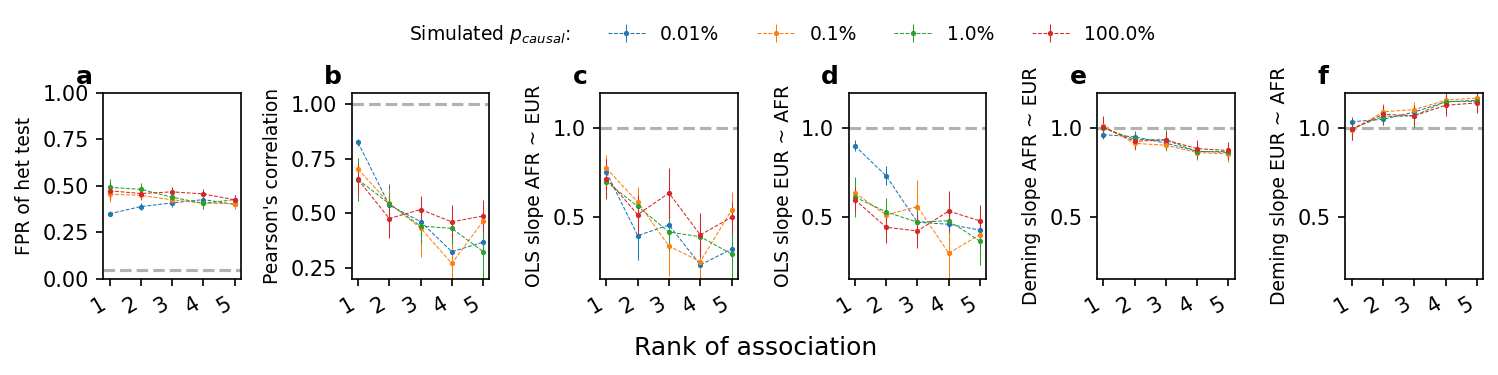

In [12]:
y_var_list = [
    "het_fpr",
    "pearsonr",
    "ols_afr~eur",
    "ols_eur~afr",
    "deming_afr~eur",
    "deming_eur~afr",
]
y_label_list = [
    "FPR of het test",
    "Pearson's correlation",
    "OLS slope AFR ~ EUR",
    "OLS slope EUR ~ AFR",
    "Deming slope AFR ~ EUR",
    "Deming slope EUR ~ AFR",
]
dict_ylim = {
    "het_fpr": [0, 1.0],
    "pearsonr": [0.2, 1.05],
    "ols_afr~eur": [0.15, 1.2],
    "ols_eur~afr": [0.15, 1.2],
    "deming_afr~eur": [0.15, 1.2],
    "deming_eur~afr": [0.15, 1.2],
}
dict_hline = {
    "het_fpr": 0.05,
    "pearsonr": 1.0,
    "ols_afr~eur": 1.0,
    "ols_eur~afr": 1.0,
    "deming_afr~eur": 1.0,
    "deming_eur~afr": 1.0,
}
# "Pearson's correlation" is not plotted because i don't think it makes sense

# makes a 2 x 2 figure
fig, axes = plt.subplots(figsize=(10, 2), ncols=len(y_var_list), nrows=1, dpi=150)
axes = axes.flatten()

for i, (y_var, y_label) in enumerate(zip(y_var_list, y_label_list)):
    ax = axes[i]
    for pcausal in df_plot.pcausal.unique():
        df_est_tmp = df_plot[df_plot.pcausal == pcausal]
        df_se_tmp = df_plot_se[df_plot_se.pcausal == pcausal]
        ax.errorbar(
            df_est_tmp.plink_assoc_p_bin,
            df_est_tmp[y_var],
            yerr=df_se_tmp[y_var] * 1.96,
            fmt=".--",
            ms=3,
            mew=1,
            label=f"{pcausal * 100}%",
            linewidth=0.5,
        )

    ax.axhline(y=dict_hline[y_var], color="black", ls="--", alpha=0.3)
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(np.arange(1, 6).astype(str).tolist(), rotation=30, ha="right")
    #     ax.set_xlabel("Rank of association")
    ax.set_ylabel(y_label, fontsize=9)
    ax.set_ylim(dict_ylim[y_var])

    # annotation
    ax.text(
        -0.2,
        1.05,
        string.ascii_lowercase[i],
        transform=ax.transAxes,
        size=12,
        weight="bold",
    )

# trick to put title in the same row
handles, labels = axes[0].get_legend_handles_labels()
ph = [plt.plot([], marker="", ls="")[0]]  # Canvas
handles = ph + handles
labels = ["Simulated $p_{causal}$:"] + labels  # Merging labels
fig.legend(
    handles,
    labels,
    ncol=5,
    loc="center",
    bbox_to_anchor=[0.5, 1.02],
    frameon=False,
    fontsize=9,
)

fig.text(
    0.5,
    -0.05,
    "Rank of association",
    fontsize=12,
    ha="center",
)


plt.tight_layout()
plt.savefig("genome-wide-main.pdf", bbox_inches="tight")
plt.show()

# Legacy code below

In [9]:
# df_rls_grouped = df_rls.groupby(["pcausal", "plink_assoc_p_bin"])
# df_plot = pd.concat(
#     [
#         df_rls_grouped.apply(lambda x: admix.data.lambda_gc(x["het_pval"])),
#         df_rls_grouped.apply(lambda x: pearsonr(x["coef1"], x["coef2"])[0]),
#     ],
#     axis=1,
# )
# df_plot.columns = ["lambda_gc", "pearsonr"]
# df_plot = df_plot.reset_index(drop=False)

Text(0, 0.5, "Pearson's correlation")

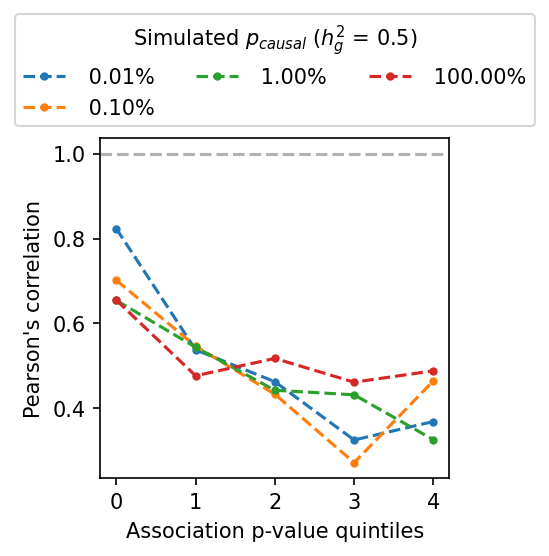

In [10]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
for pcausal in df_plot.pcausal.unique():
    df_tmp = df_plot[df_plot.pcausal == pcausal]
    ax.plot(
        df_tmp.plink_assoc_p_bin.cat.codes,
        df_tmp.pearsonr,
        ".--",
        label=f"{pcausal * 100 : .2f}%",
    )

ax.legend(
    loc="center",
    bbox_to_anchor=[0.5, 1.2],
    ncol=3,
    title="Simulated $p_{causal}$ ($h_g^2$ = 0.5)",
)
ax.axhline(y=1, color="black", ls="--", alpha=0.3)
ax.set_xticks(df_tmp.plink_assoc_p_bin.cat.codes)
ax.set_xticklabels(df_tmp.plink_assoc_p_bin.cat.codes)
ax.set_xlabel("Association p-value quintiles")
ax.set_ylabel("Pearson's correlation")